# TL;DR
## Задание 1

1. *CLIP + CatBoostRegressor* - результат *0.14* (r2)
2. *CNN + AvgPool2d* - результат *~0.77* (r2)
3. *CNN + AvgPool2d + BatchNorm2d* - результат *~0.785* (r2)

Таким образом, лучше всего с данной задачей справилась модель *CNN + AvgPool2d + BatchNorm2d*.

## Задание 2

1. *UNet + Dice Loss* - результат *0.64* (IoU)
2. *DeepLabV3 + Dice Loss* - результат *0.51* (IoU)

Лучше всего с данной задачей справилась модель *UNet + Dice Loss*.

## Задание 3

1. *UNet + Dice Loss* - результат *0.71* (IoU)
2. *UNet + Tversky Loss* - результат *0.75* (IoU)

Лучше всего с данной задачей справилась модель *UNet + Tversky Loss*.


In [2]:
import requests
from urllib.parse import urlencode
import zipfile
import pathlib
from matplotlib import pyplot as plt
from PIL import Image, ImageDraw, ImageFont
import numpy as np
import pandas as pd
import torch

In [1]:
import matplotlib.pyplot as plt
from PIL import Image, ImageOps
from skimage.io import imread
from skimage.transform import resize
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torch.nn.functional as F
import pathlib
from tqdm import tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [18]:
yd_url = "https://disk.yandex.ru/d/cXHdTIPM0eMuew"
final_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?' + urlencode(dict(public_key=yd_url))
response = requests.get(final_url)
download_url = response.json()['href']

dataset_file = pathlib.Path('dataset.zip')

if not dataset_file.exists():

    download_response = requests.get(download_url)

    with open(dataset_file, 'wb') as f:
        f.write(download_response.content)

    with zipfile.ZipFile(dataset_file, 'r') as zip_ref:
        zip_ref.extractall("dataset")

## Задание 1. Лейблинг объектов

Датасет уже загружен, находится в директории "./dataset/dataset1/"

В датасете каждому объекту соответствует некоторый параметр alpha. Необходимо обучить модель, которая сможет сопоставить аналогичному объекту значение alpha.

В рамках этого задания необходимо:
1. Исследовать данные.
2. Выбрать и обучить модель для решения задачи регресиии.
3. Определить метрику для определения качества работы модели.
4. Если обучалось несколько классификаторов, сравнить результаты работы классификаторов.
5. Продемонстрировать результаты.

Будет большим плюсом:
* Выбрать и обучить несколько моделей и провести сравнение результатов
* Произвести оценку модели по нескольким метрикам
* Продемонстрировать, как использовать обученную модель

В качестве метрики будет использоваться **коэффициент детерминации r2**.

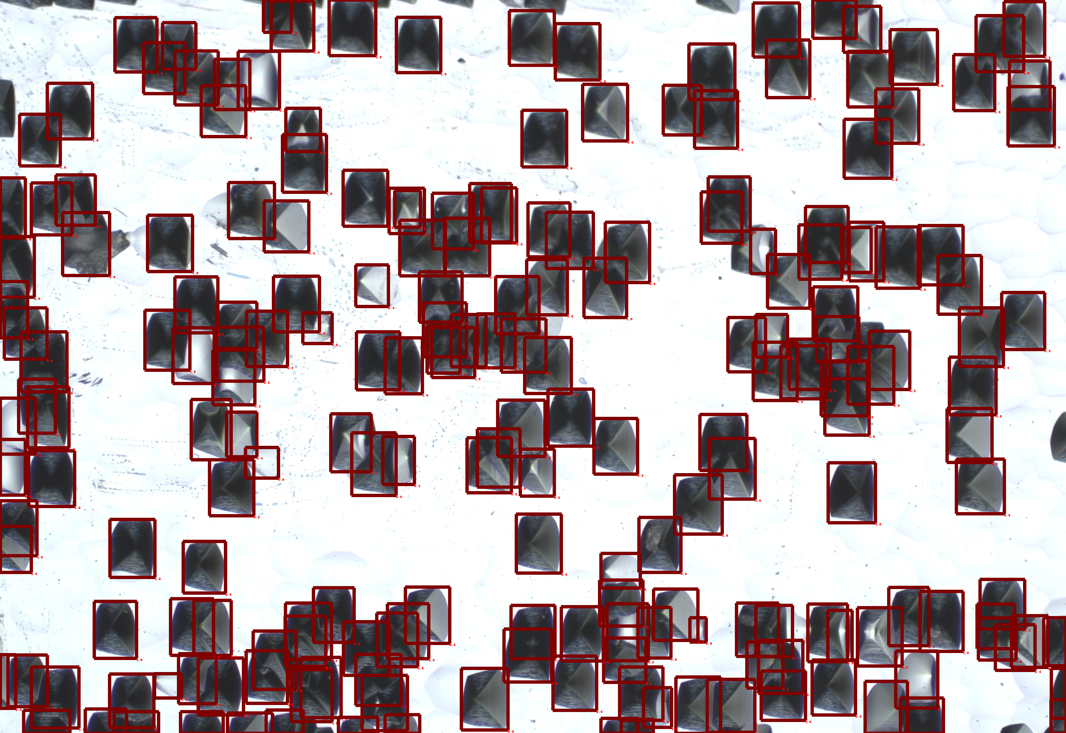

In [19]:
img_path = pathlib.Path("dataset/dataset1/images/608__Scen 608.jpg")
demo_image = Image.open(img_path)
image_width, image_height = demo_image.size

draw = ImageDraw.Draw(demo_image)

dataframe = pd.read_csv("dataset/dataset1/labels.csv")
image_labels = dataframe[dataframe["image"] == img_path.name.split("_")[-1]]

for line in image_labels.iloc():
    idx, image, x1, y1, x2, y2, alpha = line.values
    draw.line((x1, y1, x1, y2, x2, y2, x2, y1, x1, y1), fill=128, width=10)
    font = ImageFont.load_default()
#    font = ImageFont.truetype('/usr/local/lib/python3.10/dist-packages/matplotlib/mpl-data/fonts/ttf/STIXGeneral.ttf', size=36)
    draw.text((x2, y2), str(alpha), (255, 0, 0), font=font)

demo_image.resize((int(demo_image.size[0] / 3), int(demo_image.size[1] / 3)))

# **Часть 1. EDA**

In [20]:
dataframe['alpha'].unique()

array([0.6, 1. , 0.8, 0. , 0.2, 0.4, 0.7, 0.5, 0.3, 0.9])

In [6]:
dataframe[dataframe['image'] == 'Scen 646.jpg']

Unnamed: 0         image   xtl   ytl   xbr   ybr  alpha
3858        3858  Scen 646.jpg  2531    53  2666   224    0.9
3859        3859  Scen 646.jpg  2266   330  2410   506    1.0
3860        3860  Scen 646.jpg  2826   312  2970   492    1.0
3861        3861  Scen 646.jpg  3108    79  3200   235    1.0
3862        3862  Scen 646.jpg  2891     0  3036    95    1.0
3863        3863  Scen 646.jpg  2581   555  2683   669    0.0
3864        3864  Scen 646.jpg  2327   517  2461   687    1.0
3865        3865  Scen 646.jpg  2331   600  2423   707    0.6
3866        3866  Scen 646.jpg  2140   496  2250   649    0.4
3867        3867  Scen 646.jpg  2230   927  2355  1094    1.0
3868        3868  Scen 646.jpg  2243  1076  2337  1202    0.4
3869        3869  Scen 646.jpg  1977  1487  2046  1569    0.6
3870        3870  Scen 646.jpg  2545  1551  2644  1711    0.4
3871        3871  Scen 646.jpg  2192  2086  2296  2200    0.4
3872        3872  Scen 646.jpg  1470  1472  1561  1593    0.4
3873        3873  Scen 646.jpg  2723     0  2813    77    0.4
3874        3874  Scen 646.jpg  2680    49  2792   194    0.7
3875        3875  Scen 646.jpg  1888   261  2031   439    1.0
3876        3876  Scen 646.jpg  2246    79  2352   244    0.7
3877        3877  Scen 646.jpg  2709   237  2848   405    0.5
3878        3878  Scen 646.jpg  2054   411  2188   572    0.5
3879        3879  Scen 646.jpg  2033   503  2142   657    0.7
3880        3880  Scen 646.jpg  2642   513  2748   656    0.7
3881        3881  Scen 646.jpg  2668   620  2772   770    0.7
3882        3882  Scen 646.jpg  1470   418  1609   592    1.0
3883        3883  Scen 646.jpg  1913  1123  2036  1297    0.4
3884        3884  Scen 646.jpg  1908  1542  2032  1707    0.4
3885        3885  Scen 646.jpg  1565   393  1652   540    0.3
3886        3886  Scen 646.jpg  1696   250  1819   419    0.5
3887        3887  Scen 646.jpg  1653   192  1748   333    0.3
3888        3888  Scen 646.jpg  1568   100  1687   253    0.3
3889        3889  Scen 646.jpg  1525     0  1664    73    0.9
3890        3890  Scen 646.jpg  2294  1169  2398  1340    0.3
3891        3891  Scen 646.jpg  1495  1113  1617  1276    0.7
3892        3892  Scen 646.jpg  1487  1204  1606  1345    0.7
3893        3893  Scen 646.jpg   545  1656   662  1826    0.7
3894        3894  Scen 646.jpg  2011   913  2101  1047    0.3
3895        3895  Scen 646.jpg  1614   707  1705   840    0.3
3896        3896  Scen 646.jpg   814   383   916   538    0.5
3897        3897  Scen 646.jpg  1135   214  1274   387    0.9
3898        3898  Scen 646.jpg   651    19   778   184    0.9
3899        3899  Scen 646.jpg   514   462   665   649    1.0
3900        3900  Scen 646.jpg  1627   321  1753   476    0.8
3901        3901  Scen 646.jpg  1236   852  1378  1034    0.9
3902        3902  Scen 646.jpg   647   357   783   533    0.9
3903        3903  Scen 646.jpg   814  1754   933  1917    0.6
3904        3904  Scen 646.jpg   612  1897   734  2066    0.6
3905        3905  Scen 646.jpg   183  1558   253  1700    0.0
3906        3906  Scen 646.jpg  1695   703  1792   840    1.0
3907        3907  Scen 646.jpg   944   820  1093  1016    1.0
3908        3908  Scen 646.jpg   839   377   962   549    0.2
3909        3909  Scen 646.jpg   521     6   662   189    1.0
3910        3910  Scen 646.jpg  1147   530  1253   631    0.0
3911        3911  Scen 646.jpg   977   488  1119   663    0.4
3912        3912  Scen 646.jpg   139    11   264   184    0.4
3913        3913  Scen 646.jpg     0   399    41   576    1.0
3914        3914  Scen 646.jpg   113   467   255   666    1.0
3915        3915  Scen 646.jpg   246   496   385   672    1.0
3916        3916  Scen 646.jpg     0  1079   116  1256    1.0
3917        3917  Scen 646.jpg     0   704    88   878    1.0

In [7]:
dataframe['image'].unique()

array(['Scen 1235.jpg', 'Scen 367.jpg', 'Scen 401.jpg', 'Scen 402.jpg',
       'Scen 436.jpg', 'Scen 439.jpg', 'Scen 470.jpg', 'Scen 539.jpg',
       'Scen 542.jpg', 'Scen 574.jpg', 'Scen 678.jpg', 'Scen 864.jpg',
       'Scen 865.jpg', 'Scen 608.jpg', 'Scen 609.jpg', 'Scen 610.jpg',
       'Scen 611.jpg', 'Scen 612.jpg', 'Scen 613.jpg', 'Scen 614.jpg',
       'Scen 615.jpg', 'Scen 616.jpg', 'Scen 642.jpg', 'Scen 643.jpg',
       'Scen 644.jpg', 'Scen 645.jpg', 'Scen 646.jpg', 'Scen 647.jpg',
       'Scen 648.jpg', 'Scen 649.jpg', 'Scen 650.jpg', 'Scen 651.jpg',
       'Scen 652.jpg'], dtype=object)

# **Модель 1. CLIP + CatBoostRegressor**

In [8]:
#installing some dependencies, CLIP was release in PyTorch
import subprocess

CUDA_version = [s for s in subprocess.check_output(["nvcc", "--version"]).decode("UTF-8").split(", ") if s.startswith("release")][0].split(" ")[-1]
print("CUDA version:", CUDA_version)

!pip install torch torchvision -f https://download.pytorch.org/whl/torch_stable.html ftfy regex

import numpy as np
import torch
import os

print("Torch version:", torch.__version__)
#Your notebook process will restart after these installs

CUDA version: 12.1
Looking in links: https://download.pytorch.org/whl/torch_stable.html
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.4/54.4 kB 1.7 MB/s eta 0:00:00
Torch version: 2.1.2


In [11]:
#clone the CLIP repository
!git clone https://github.com/openai/CLIP.git 
%cd CLIP

Cloning into 'CLIP'...
remote: Enumerating objects: 256, done.
remote: Counting objects: 100% (13/13), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 256 (delta 6), reused 4 (delta 0), pack-reused 243
Receiving objects: 100% (256/256), 8.93 MiB | 24.12 MiB/s, done.
Resolving deltas: 100% (130/130), done.
/kaggle/working/CLIP


In [14]:
!pip install roboflow>=1.0.1 torch torchvision -f https://download.pytorch.org/whl/torch_stable.html ftfy regex


In [15]:
import torch
import clip
from PIL import Image
import glob

def argmax(iterable):
    return max(enumerate(iterable), key=lambda x: x[1])[0]

device = "cuda" if torch.cuda.is_available() else "cpu"
model, transform = clip.load("ViT-B/32", device=device)

100%|████████████████████████████████████████| 338M/338M [00:02<00:00, 149MiB/s]


In [21]:
# pathlib.Path("dataset/dataset1/images/608__Scen 608.jpg")

res = None

for _, row in dataframe.iterrows():
    image = [*row['image'].split(), *row['image'].split()[-1].split('.')]
    name = f"{image[2]}__{image[0]} {image[1]}"
    cur_image = Image.open("dataset/dataset1/images/" + name)
    cur_image = cur_image.crop(tuple(row[['xtl', 'ytl', 'xbr', 'ybr']]))
#     cur_image.show()
    image = transform(cur_image).unsqueeze(0).to(device)
    with torch.no_grad():
        image_features = model.encode_image(image).view(-x1)
        if res is None:
            res = image_features
        else:
            res = torch.cat([res, image_features], 0)
#     left, top, right, bottom)
#     im1 = im.cro()

In [22]:
res = res.view(-1, 512).cpu().numpy()

In [23]:
df = pd.DataFrame(res)
df

0         1         2         3         4         5         6    \
0     0.171997  0.071045  0.046112  0.195190  0.107361 -0.169556  0.284424   
1     0.171997  0.071045  0.046112  0.195190  0.107361 -0.169556  0.284424   
2     0.171997  0.071045  0.046112  0.195190  0.107361 -0.169556  0.284424   
3     0.171997  0.071045  0.046112  0.195190  0.107361 -0.169556  0.284424   
4     0.171997  0.071045  0.046112  0.195190  0.107361 -0.169556  0.284424   
...        ...       ...       ...       ...       ...       ...       ...   
4377 -0.128418  0.223877  0.032501  0.221191  0.038300 -0.252441  0.356201   
4378 -0.128418  0.223877  0.032501  0.221191  0.038300 -0.252441  0.356201   
4379 -0.128418  0.223877  0.032501  0.221191  0.038300 -0.252441  0.356201   
4380 -0.128418  0.223877  0.032501  0.221191  0.038300 -0.252441  0.356201   
4381 -0.128418  0.223877  0.032501  0.221191  0.038300 -0.252441  0.356201   

           7         8         9    ...       502       503       504  \
0     0.922852  0.357178  0.232910  ... -0.299561  0.131348  0.587891   
1     0.922852  0.357178  0.232910  ... -0.299561  0.131348  0.587891   
2     0.922852  0.357178  0.232910  ... -0.299561  0.131348  0.587891   
3     0.922852  0.357178  0.232910  ... -0.299561  0.131348  0.587891   
4     0.922852  0.357178  0.232910  ... -0.299561  0.131348  0.587891   
...        ...       ...       ...  ...       ...       ...       ...   
4377  0.707031  0.337158 -0.195068  ... -0.368652  0.099365  0.920410   
4378  0.707031  0.337158 -0.195068  ... -0.368652  0.099365  0.920410   
4379  0.707031  0.337158 -0.195068  ... -0.368652  0.099365  0.920410   
4380  0.707031  0.337158 -0.195068  ... -0.368652  0.099365  0.920410   
4381  0.707031  0.337158 -0.195068  ... -0.368652  0.099365  0.920410   

           505       506       507       508       509       510       511  
0    -0.088440 -0.218872 -0.283936 -0.115601  0.806641 -0.216797 -0.172974  
1    -0.088440 -0.218872 -0.283936 -0.115601  0.806641 -0.216797 -0.172974  
2    -0.088440 -0.218872 -0.283936 -0.115601  0.806641 -0.216797 -0.172974  
3    -0.088440 -0.218872 -0.283936 -0.115601  0.806641 -0.216797 -0.172974  
4    -0.088440 -0.218872 -0.283936 -0.115601  0.806641 -0.216797 -0.172974  
...        ...       ...       ...       ...       ...       ...       ...  
4377 -0.150391 -0.061859 -0.344971 -0.060730  0.910645 -0.044189 -0.443115  
4378 -0.150391 -0.061859 -0.344971 -0.060730  0.910645 -0.044189 -0.443115  
4379 -0.150391 -0.061859 -0.344971 -0.060730  0.910645 -0.044189 -0.443115  
4380 -0.150391 -0.061859 -0.344971 -0.060730  0.910645 -0.044189 -0.443115  
4381 -0.150391 -0.061859 -0.344971 -0.060730  0.910645 -0.044189 -0.443115  

[4382 rows x 512 columns]

In [24]:
result = pd.concat([dataframe, df], axis=1, join='inner')
result

Unnamed: 0          image   xtl  ytl   xbr   ybr  alpha         0  \
0              0  Scen 1235.jpg  1348  317  1452   443    0.6  0.171997   
1              1  Scen 1235.jpg  2455   33  2551   168    1.0  0.171997   
2              2  Scen 1235.jpg  2089  293  2232   479    1.0  0.171997   
3              3  Scen 1235.jpg  2897  676  3027   856    1.0  0.171997   
4              4  Scen 1235.jpg  2955  575  3095   793    0.8  0.171997   
...          ...            ...   ...  ...   ...   ...    ...       ...   
4377        4377   Scen 652.jpg  1496  560  1641   718    0.9 -0.128418   
4378        4378   Scen 652.jpg  1491  445  1603   577    0.3 -0.128418   
4379        4379   Scen 652.jpg  1279  492  1419   670    0.9 -0.128418   
4380        4380   Scen 652.jpg  1299  527  1448   706    0.9 -0.128418   
4381        4381   Scen 652.jpg  1300  845  1440  1026    0.5 -0.128418   

             1         2  ...       502       503       504       505  \
0     0.071045  0.046112  ... -0.299561  0.131348  0.587891 -0.088440   
1     0.071045  0.046112  ... -0.299561  0.131348  0.587891 -0.088440   
2     0.071045  0.046112  ... -0.299561  0.131348  0.587891 -0.088440   
3     0.071045  0.046112  ... -0.299561  0.131348  0.587891 -0.088440   
4     0.071045  0.046112  ... -0.299561  0.131348  0.587891 -0.088440   
...        ...       ...  ...       ...       ...       ...       ...   
4377  0.223877  0.032501  ... -0.368652  0.099365  0.920410 -0.150391   
4378  0.223877  0.032501  ... -0.368652  0.099365  0.920410 -0.150391   
4379  0.223877  0.032501  ... -0.368652  0.099365  0.920410 -0.150391   
4380  0.223877  0.032501  ... -0.368652  0.099365  0.920410 -0.150391   
4381  0.223877  0.032501  ... -0.368652  0.099365  0.920410 -0.150391   

           506       507       508       509       510       511  
0    -0.218872 -0.283936 -0.115601  0.806641 -0.216797 -0.172974  
1    -0.218872 -0.283936 -0.115601  0.806641 -0.216797 -0.172974  
2    -0.218872 -0.283936 -0.115601  0.806641 -0.216797 -0.172974  
3    -0.218872 -0.283936 -0.115601  0.806641 -0.216797 -0.172974  
4    -0.218872 -0.283936 -0.115601  0.806641 -0.216797 -0.172974  
...        ...       ...       ...       ...       ...       ...  
4377 -0.061859 -0.344971 -0.060730  0.910645 -0.044189 -0.443115  
4378 -0.061859 -0.344971 -0.060730  0.910645 -0.044189 -0.443115  
4379 -0.061859 -0.344971 -0.060730  0.910645 -0.044189 -0.443115  
4380 -0.061859 -0.344971 -0.060730  0.910645 -0.044189 -0.443115  
4381 -0.061859 -0.344971 -0.060730  0.910645 -0.044189 -0.443115  

[4382 rows x 519 columns]

In [29]:
!pip install optuna

In [26]:
from sklearn.model_selection import train_test_split

X, y = result.drop(columns=['alpha', 'image', 'Unnamed: 0']), np.array(result['alpha'])
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.33, random_state=42)

In [33]:
from sklearn.metrics import r2_score

def check_r2(model, x_val, y_val):
    y_pred = model.predict(x_val)
    return float(r2_score(y_val, y_pred))

In [36]:
def standard_objective(trial):
    param = {}
    param['learning_rate'] = trial.suggest_float("learning_rate", 0.001, 0.01, step=0.004)
    param['depth'] = trial.suggest_int('depth', 5, 11)
    param['l2_leaf_reg'] = trial.suggest_float('l2_leaf_reg', 1.0, 5.0, step=0.5)
    param['min_child_samples'] = trial.suggest_categorical('min_child_samples', [1, 4, 8, 16, 32])
    param['grow_policy'] = 'Depthwise'
    param['iterations'] = 2000
    param['eval_metric'] = 'RMSE'
    param['od_type'] = 'iter'
    param['od_wait'] = 50
    param['random_state'] = 42
    param['logging_level'] = 'Silent'
    
    regressor = CatBoostRegressor(**param)
    regressor.fit(X_train.copy(), y_train.copy(),
                  early_stopping_rounds=100)
    return check_r2(regressor, X_val.copy(), y_val.copy())

In [38]:
import optuna
from catboost import CatBoostRegressor

standard_study = optuna.create_study(direction='maximize')
standard_study.optimize(standard_objective, n_trials=50)

[I 2024-07-18 21:14:15,997] A new study created in memory with name: no-name-e8a38541-fc31-4531-a25b-0e11743f07c7
[I 2024-07-18 21:15:45,563] Trial 0 finished with value: 0.08864880420910581 and parameters: {'learning_rate': 0.001, 'depth': 6, 'l2_leaf_reg': 1.5, 'min_child_samples': 8}. Best is trial 0 with value: 0.08864880420910581.
/opt/conda/lib/python3.10/site-packages/optuna/distributions.py:685: UserWarning: The distribution is specified by [0.001, 0.01] and step=0.004, but the range is not divisible by `step`. It will be replaced by [0.001, 0.009].
  warnings.warn(
[I 2024-07-18 21:19:51,102] Trial 1 finished with value: 0.08701985533022005 and parameters: {'learning_rate': 0.001, 'depth': 10, 'l2_leaf_reg': 1.5, 'min_child_samples': 32}. Best is trial 0 with value: 0.08864880420910581.
/opt/conda/lib/python3.10/site-packages/optuna/distributions.py:685: UserWarning: The distribution is specified by [0.001, 0.01] and step=0.004, but the range is not divisible by `step`. It wil

In [39]:
standard_study.best_params

{'learning_rate': 0.009,
 'depth': 6,
 'l2_leaf_reg': 1.0,
 'min_child_samples': 32}

In [41]:
standard_study.best_value

0.14130148045667923

Таким образом, лучший результат был достигнут на 44 эпохе и равен **~0.14**. К сожалению, данный способ показал свою неэффективность, поэтому было принято использовать свертки для выделения признаков с фотографий.

# **Модель 2. CNN + AvgPool2d**

In [100]:
import torch
import torchvision.transforms as transforms
import os
from sklearn.metrics import r2_score

In [101]:
class CustomImageDataset(torch.utils.data.Dataset):
    def __init__(self, df):
        self.img_labels = df
        self.dataset_dir = 'dataset/dataset1/'

    def __len__(self):
        return len(self.img_labels)
    
    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image

    def __getitem__(self, idx):
        transform = transforms.Compose([
            transforms.ToTensor(),
            # transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
        
        image = [*self.img_labels.loc[idx, 'image'].split(),
                 *self.img_labels.loc[idx, 'image'].split()[-1].split('.')]
        name = f"{image[2]}__{image[0]} {image[1]}"
        bboxes = [
            self.img_labels.loc[idx, 'xtl'],
            self.img_labels.loc[idx, 'ytl'],
            self.img_labels.loc[idx, 'xbr'],
            self.img_labels.loc[idx, 'ybr']
        ]
        # print(bboxes)
        x = self.load_sample(os.path.join(self.dataset_dir, 'images', name))
        x = x.crop(bboxes)
        x = np.array(x.resize((128, 128)))
        x = np.array(x / 255, dtype='float32')
        x = transform(x)
        return x, self.img_labels.loc[idx, 'alpha']

In [97]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(dataframe, test_size=0.2)
train, val = train_test_split(train, test_size=0.25)

In [98]:
train = train.reset_index(drop=True)
test = test.reset_index(drop=True)
val = val.reset_index(drop=True)

In [102]:
train_dataset = CustomImageDataset(train)
test_dataset = CustomImageDataset(test)
val_dataset = CustomImageDataset(val)

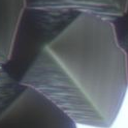

In [103]:
transforms.ToPILImage()(val_dataset[80][0])

In [94]:
import torch.nn as nn
import numpy as np

class ConvNet(nn.Module):
    # initialize the class and the parameters
    def __init__(self):
        super(ConvNet, self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3),
            nn.AvgPool2d(2),
            nn.ReLU()
        )
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3),
            nn.AvgPool2d(2),
            nn.ReLU()
        )
        
        self.layer3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3),
            nn.AvgPool2d(2),
            nn.ReLU()
        )
        
        self.layer4 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3),
            nn.AvgPool2d(2),
            nn.ReLU()
        )
        
        self.fc = nn.Linear(4608, 1)
    
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out).float()
        return out

model = ConvNet()
print(model)

ConvNet(
  (layer1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (2): ReLU()
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (2): ReLU()
  )
  (layer3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (2): ReLU()
  )
  (layer4): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (1): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (2): ReLU()
  )
  (fc): Linear(in_features=4608, out_features=1, bias=True)
)


In [126]:
b = torch.rand(10, 3, 128, 128)
model(b).size()

torch.Size([10, 1])

In [105]:
def fit_epoch(model, train_loader, criterion, optimizer):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
    
    all_labels = None
    all_preds = None
    
    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs.view(-1).float(), labels.view(-1).float())
        loss.backward()
        optimizer.step()
#         preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        
        if all_labels is None:
            all_labels = labels
        else:
            all_labels = torch.cat([all_labels, labels], 0)
        
        if all_preds is None:
            all_preds = outputs
        else:
            all_preds = torch.cat([all_preds, outputs], 0)
        
        # running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)

    train_loss = running_loss / processed_data
    train_score = r2_score(all_labels.view(-1).detach().cpu().numpy(), all_preds.view(-1).detach().cpu().numpy())
    return train_loss, train_score

In [106]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    all_labels = None
    all_preds = None
    
    for inputs, labels in val_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs.view(-1).float(), labels.view(-1).float())
#             preds = torch.argmax(outputs, 1)
            
        if all_labels is None:
            all_labels = labels
        else:
            all_labels = torch.cat([all_labels, labels], 0)
        
        if all_preds is None:
            all_preds = outputs
        else:
            all_preds = torch.cat([all_preds, outputs], 0)
        
        running_loss += loss.item() * inputs.size(0)
#         running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
        
    # all_labels = torch.stack(all_labels).view(-1)
    # all_preds = torch.stack(all_preds).view(-1)
        
    val_loss = running_loss / processed_size
    val_score = r2_score(all_labels.view(-1).detach().cpu().numpy(), all_preds.view(-1).detach().cpu().numpy())
    return val_loss, val_score

In [107]:
def train(train_files, val_files, model, epochs, batch_size):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = torch.optim.AdamW(model.parameters())
        criterion = nn.MSELoss()

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
            print("loss", train_loss)

            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))

            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))

    return history

In [108]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []

        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)

    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [147]:
convnet = ConvNet().to(device)

In [148]:
history = train(train_dataset, val_dataset, convnet, epochs=30, batch_size=64)

epoch:   0%|          | 0/30 [00:00<?, ?it/s]

loss 0.12671625087409077


epoch:   3%|▎         | 1/30 [01:39<47:52, 99.05s/it]


Epoch 001 train_loss: 0.1267     val_loss 0.0227 train_acc -0.4116 val_acc 0.7318
loss 0.02448581827058821


epoch:   7%|▋         | 2/30 [03:20<46:56, 100.58s/it]


Epoch 002 train_loss: 0.0245     val_loss 0.0223 train_acc 0.7272 val_acc 0.7368
loss 0.02358210550605559


epoch:  10%|█         | 3/30 [04:58<44:45, 99.46s/it] 


Epoch 003 train_loss: 0.0236     val_loss 0.0252 train_acc 0.7373 val_acc 0.7025
loss 0.025001254410424823


epoch:  13%|█▎        | 4/30 [06:36<42:48, 98.77s/it]


Epoch 004 train_loss: 0.0250     val_loss 0.0265 train_acc 0.7215 val_acc 0.6872
loss 0.025486952113483775


epoch:  17%|█▋        | 5/30 [08:15<41:14, 98.98s/it]


Epoch 005 train_loss: 0.0255     val_loss 0.0214 train_acc 0.7161 val_acc 0.7470
loss 0.02319889109123844


epoch:  20%|██        | 6/30 [09:53<39:25, 98.55s/it]


Epoch 006 train_loss: 0.0232     val_loss 0.0216 train_acc 0.7416 val_acc 0.7453
loss 0.022685789681412563


epoch:  23%|██▎       | 7/30 [11:30<37:34, 98.03s/it]


Epoch 007 train_loss: 0.0227     val_loss 0.0195 train_acc 0.7473 val_acc 0.7701
loss 0.02207063298950275


epoch:  27%|██▋       | 8/30 [13:08<35:58, 98.13s/it]


Epoch 008 train_loss: 0.0221     val_loss 0.0413 train_acc 0.7541 val_acc 0.5130
loss 0.027228331661824267


epoch:  30%|███       | 9/30 [14:44<34:05, 97.42s/it]


Epoch 009 train_loss: 0.0272     val_loss 0.0198 train_acc 0.6967 val_acc 0.7667
loss 0.022527498592830958


epoch:  33%|███▎      | 10/30 [16:22<32:28, 97.40s/it]


Epoch 010 train_loss: 0.0225     val_loss 0.0194 train_acc 0.7490 val_acc 0.7711
loss 0.021683974387166707


epoch:  37%|███▋      | 11/30 [17:57<30:39, 96.83s/it]


Epoch 011 train_loss: 0.0217     val_loss 0.0343 train_acc 0.7584 val_acc 0.5957
loss 0.02558296189758263


epoch:  40%|████      | 12/30 [19:32<28:51, 96.18s/it]


Epoch 012 train_loss: 0.0256     val_loss 0.0211 train_acc 0.7150 val_acc 0.7507
loss 0.021663501359737807


epoch:  43%|████▎     | 13/30 [21:12<27:37, 97.48s/it]


Epoch 013 train_loss: 0.0217     val_loss 0.0230 train_acc 0.7587 val_acc 0.7285
loss 0.023155488307719633


epoch:  47%|████▋     | 14/30 [22:55<26:23, 98.96s/it]


Epoch 014 train_loss: 0.0232     val_loss 0.0208 train_acc 0.7421 val_acc 0.7542
loss 0.023007945756851788


epoch:  50%|█████     | 15/30 [24:34<24:45, 99.03s/it]


Epoch 015 train_loss: 0.0230     val_loss 0.0234 train_acc 0.7437 val_acc 0.7238
loss 0.020712357649474746


epoch:  57%|█████▋    | 17/30 [27:49<21:19, 98.42s/it]


Epoch 017 train_loss: 0.0207     val_loss 0.0193 train_acc 0.7693 val_acc 0.7722
loss 0.02140189283435294


epoch:  60%|██████    | 18/30 [29:25<19:32, 97.70s/it]


Epoch 018 train_loss: 0.0214     val_loss 0.0202 train_acc 0.7616 val_acc 0.7623
loss 0.020833801007524837


epoch:  63%|██████▎   | 19/30 [31:06<18:06, 98.78s/it]


Epoch 019 train_loss: 0.0208     val_loss 0.0202 train_acc 0.7679 val_acc 0.7622
loss 0.021716870764437693


epoch:  67%|██████▋   | 20/30 [32:47<16:34, 99.48s/it]


Epoch 020 train_loss: 0.0217     val_loss 0.0197 train_acc 0.7581 val_acc 0.7675
loss 0.0206467009956071


epoch:  70%|███████   | 21/30 [34:22<14:42, 98.04s/it]


Epoch 021 train_loss: 0.0206     val_loss 0.0183 train_acc 0.7700 val_acc 0.7844
loss 0.0202999275540607


epoch:  73%|███████▎  | 22/30 [35:59<13:01, 97.68s/it]


Epoch 022 train_loss: 0.0203     val_loss 0.0185 train_acc 0.7739 val_acc 0.7814
loss 0.019989536547837736


epoch:  77%|███████▋  | 23/30 [37:33<11:16, 96.65s/it]


Epoch 023 train_loss: 0.0200     val_loss 0.0181 train_acc 0.7773 val_acc 0.7870
loss 0.019100074347638763


epoch:  80%|████████  | 24/30 [39:08<09:35, 95.99s/it]


Epoch 024 train_loss: 0.0191     val_loss 0.0203 train_acc 0.7872 val_acc 0.7601
loss 0.019376754969120297


epoch:  83%|████████▎ | 25/30 [40:42<07:57, 95.56s/it]


Epoch 025 train_loss: 0.0194     val_loss 0.0173 train_acc 0.7841 val_acc 0.7955
loss 0.01919733906445438


epoch:  87%|████████▋ | 26/30 [42:17<06:21, 95.36s/it]


Epoch 026 train_loss: 0.0192     val_loss 0.0175 train_acc 0.7861 val_acc 0.7942
loss 0.018401260240729245


epoch:  90%|█████████ | 27/30 [43:56<04:49, 96.42s/it]


Epoch 027 train_loss: 0.0184     val_loss 0.0176 train_acc 0.7950 val_acc 0.7926
loss 0.01825136617407248


epoch:  93%|█████████▎| 28/30 [45:32<03:12, 96.24s/it]


Epoch 028 train_loss: 0.0183     val_loss 0.0193 train_acc 0.7967 val_acc 0.7721
loss 0.019185242947627603


epoch:  97%|█████████▋| 29/30 [47:09<01:36, 96.46s/it]


Epoch 029 train_loss: 0.0192     val_loss 0.0199 train_acc 0.7863 val_acc 0.7650
loss 0.01899726012696142


epoch: 100%|██████████| 30/30 [48:43<00:00, 97.45s/it]


Epoch 030 train_loss: 0.0190     val_loss 0.0194 train_acc 0.7884 val_acc 0.7716


In [156]:
from IPython.display import FileLink

FileLink('convnet_30_epochs.pt')

/kaggle/working/convnet_30_epochs.pt

In [149]:
torch.save(convnet, 'convnet_30_epochs.pt')

In [109]:
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
criterion = nn.MSELoss()
_, cur_score = eval_epoch(convnet, test_loader, criterion)
cur_score

0.775958572924273

Text(0.5, 1.0, 'CNN + AvgPool2d Training')

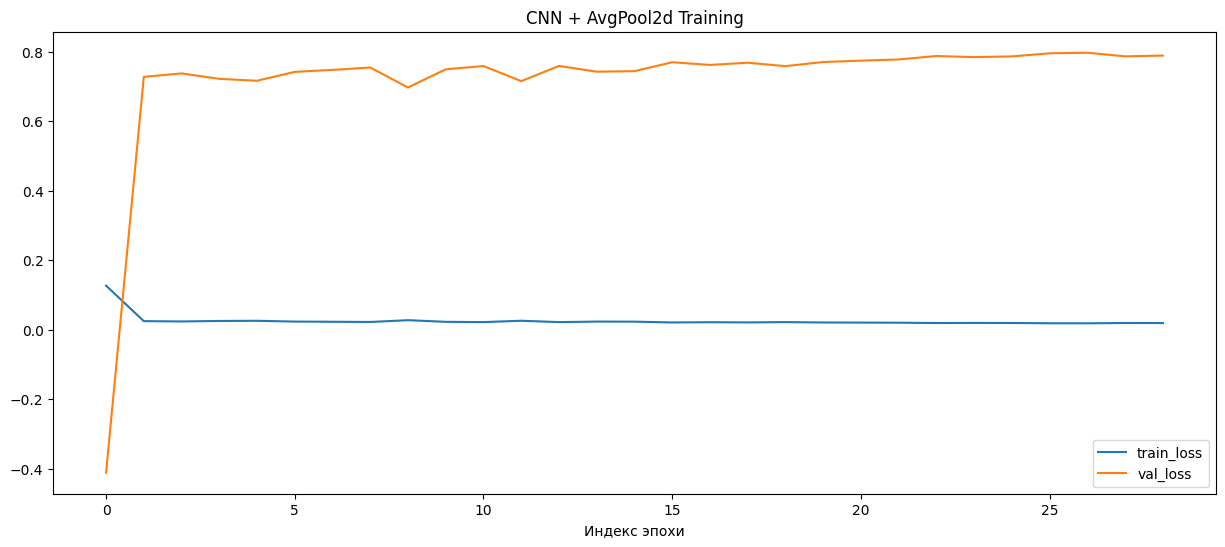

In [112]:
plt.figure(figsize=(15, 6))
for i in range(0, 4, 2):
    plt.plot(np.array(history)[:, i], '-')
plt.legend(['train_loss', 'val_loss'])
plt.xlabel('Индекс эпохи')
plt.title('CNN + AvgPool2d Training')

Text(0.5, 1.0, 'CNN + AvgPool2d Training')

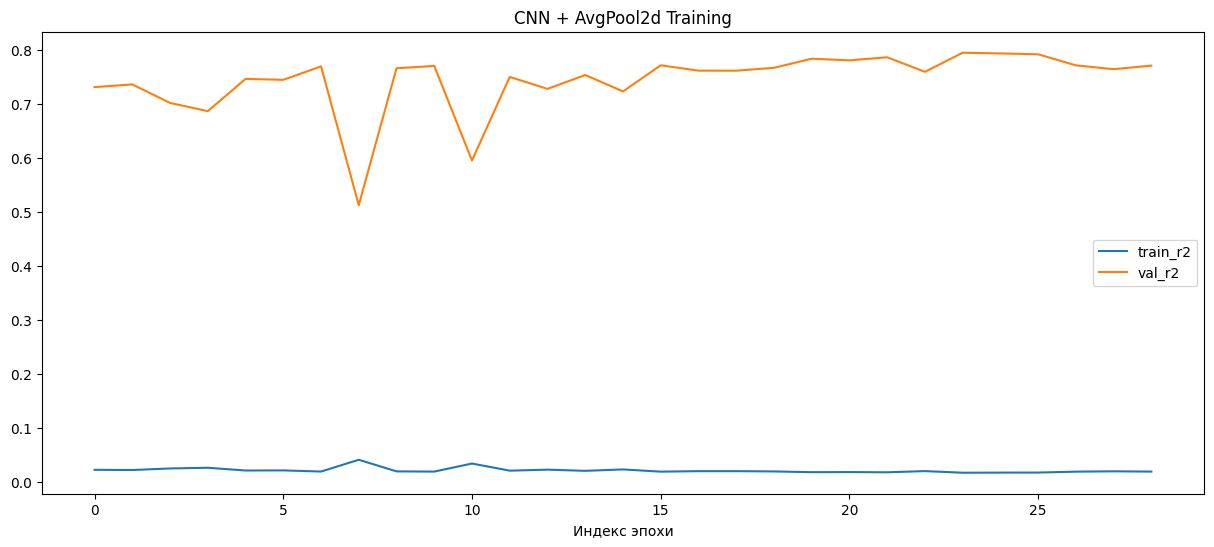

In [113]:
plt.figure(figsize=(15, 6))
for i in range(1, 4, 2):
    plt.plot(np.array(history)[:, i], '-')
plt.legend(['train_r2', 'val_r2'])
plt.xlabel('Индекс эпохи')
plt.title('CNN + AvgPool2d Training')

# **Модель 3. CNN + AvgPool2d + BatchNorm2d**

In [17]:
import torch.nn as nn
import numpy as np

class ConvNetV2(nn.Module):
    # initialize the class and the parameters
    def __init__(self):
        super(ConvNetV2, self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3),
            nn.BatchNorm2d(16),
            nn.AvgPool2d(2),
            nn.ReLU()
        )
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3),
            nn.BatchNorm2d(32),
            nn.AvgPool2d(2),
            nn.ReLU()
        )
        
        self.layer3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.AvgPool2d(2),
            nn.ReLU()
        )
        
        self.layer4 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3),
            nn.BatchNorm2d(128),
            nn.AvgPool2d(2),
            nn.ReLU()
        )
        
        self.fc = nn.Linear(4608, 1)
    
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out).float()
        return out

convnetv2 = ConvNetV2().to(device)
print(convnetv2)

ConvNetV2(
  (layer1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (3): ReLU()
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (3): ReLU()
  )
  (layer3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (2): ReLU()
  )
  (layer4): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (3): ReLU()
  )
  (fc): Linear(in_features=4608, out_features=1, bias=True)
)


In [21]:
history = train(train_dataset, val_dataset, convnetv2, epochs=30, batch_size=64)

epoch:   0%|          | 0/30 [00:00<?, ?it/s]

loss 0.19975210186462605


epoch:   3%|▎         | 1/30 [02:09<1:02:32, 129.39s/it]


Epoch 001 train_loss: 0.1998     val_loss 0.0450 train_acc -1.2163 val_acc 0.4708
loss 0.02706817159630483


epoch:   7%|▋         | 2/30 [04:17<59:59, 128.54s/it]  


Epoch 002 train_loss: 0.0271     val_loss 0.0417 train_acc 0.6997 val_acc 0.5103
loss 0.023493296144986624


epoch:  10%|█         | 3/30 [06:25<57:47, 128.44s/it]


Epoch 003 train_loss: 0.0235     val_loss 0.0285 train_acc 0.7393 val_acc 0.6657
loss 0.022475149272692983


epoch:  13%|█▎        | 4/30 [08:28<54:41, 126.22s/it]


Epoch 004 train_loss: 0.0225     val_loss 0.0405 train_acc 0.7506 val_acc 0.5245
loss 0.022848096956843384


epoch:  17%|█▋        | 5/30 [10:35<52:43, 126.56s/it]


Epoch 005 train_loss: 0.0228     val_loss 0.0198 train_acc 0.7465 val_acc 0.7678
loss 0.020226330778460887


epoch:  20%|██        | 6/30 [12:41<50:34, 126.44s/it]


Epoch 006 train_loss: 0.0202     val_loss 0.0299 train_acc 0.7756 val_acc 0.6483
loss 0.021996941978800786


epoch:  23%|██▎       | 7/30 [14:47<48:24, 126.30s/it]


Epoch 007 train_loss: 0.0220     val_loss 0.0278 train_acc 0.7559 val_acc 0.6739
loss 0.019881855140764782


epoch:  27%|██▋       | 8/30 [16:52<46:08, 125.82s/it]


Epoch 008 train_loss: 0.0199     val_loss 0.0253 train_acc 0.7794 val_acc 0.7029
loss 0.019781005573054972


epoch:  30%|███       | 9/30 [18:55<43:43, 124.94s/it]


Epoch 009 train_loss: 0.0198     val_loss 0.0205 train_acc 0.7805 val_acc 0.7587
loss 0.017965354763901306


epoch:  33%|███▎      | 10/30 [21:00<41:39, 124.99s/it]


Epoch 010 train_loss: 0.0180     val_loss 0.0234 train_acc 0.8007 val_acc 0.7255
loss 0.01860890196582453


epoch:  37%|███▋      | 11/30 [23:07<39:46, 125.63s/it]


Epoch 011 train_loss: 0.0186     val_loss 0.0182 train_acc 0.7935 val_acc 0.7860
loss 0.018119412192244146


epoch:  40%|████      | 12/30 [25:15<37:53, 126.32s/it]


Epoch 012 train_loss: 0.0181     val_loss 0.0270 train_acc 0.7990 val_acc 0.6822
loss 0.019608623001588398


epoch:  43%|████▎     | 13/30 [27:24<35:58, 126.95s/it]


Epoch 013 train_loss: 0.0196     val_loss 0.0180 train_acc 0.7824 val_acc 0.7886
loss 0.01683731151736218


epoch:  47%|████▋     | 14/30 [29:33<34:00, 127.53s/it]


Epoch 014 train_loss: 0.0168     val_loss 0.0186 train_acc 0.8132 val_acc 0.7811
loss 0.017456084005733105


epoch:  50%|█████     | 15/30 [31:41<31:56, 127.75s/it]


Epoch 015 train_loss: 0.0175     val_loss 0.0183 train_acc 0.8063 val_acc 0.7852
loss 0.01616105517298777


epoch:  53%|█████▎    | 16/30 [33:45<29:35, 126.79s/it]


Epoch 016 train_loss: 0.0162     val_loss 0.0178 train_acc 0.8207 val_acc 0.7905
loss 0.015964278490587364


epoch:  57%|█████▋    | 17/30 [35:53<27:30, 126.96s/it]


Epoch 017 train_loss: 0.0160     val_loss 0.0184 train_acc 0.8229 val_acc 0.7836
loss 0.016233156826432164


epoch:  60%|██████    | 18/30 [38:00<25:23, 127.00s/it]


Epoch 018 train_loss: 0.0162     val_loss 0.0193 train_acc 0.8199 val_acc 0.7728
loss 0.016247247344328024


epoch:  63%|██████▎   | 19/30 [40:07<23:18, 127.10s/it]


Epoch 019 train_loss: 0.0162     val_loss 0.0181 train_acc 0.8197 val_acc 0.7872
loss 0.014807322789749054


epoch:  67%|██████▋   | 20/30 [42:11<21:02, 126.20s/it]


Epoch 020 train_loss: 0.0148     val_loss 0.0212 train_acc 0.8357 val_acc 0.7513
loss 0.01683476318915685


epoch:  70%|███████   | 21/30 [44:21<19:05, 127.25s/it]


Epoch 021 train_loss: 0.0168     val_loss 0.0176 train_acc 0.8132 val_acc 0.7930
loss 0.014799309942638856


epoch:  73%|███████▎  | 22/30 [46:29<17:00, 127.54s/it]


Epoch 022 train_loss: 0.0148     val_loss 0.0194 train_acc 0.8358 val_acc 0.7724
loss 0.014957231142001065


epoch:  77%|███████▋  | 23/30 [48:37<14:53, 127.67s/it]


Epoch 023 train_loss: 0.0150     val_loss 0.0213 train_acc 0.8340 val_acc 0.7494
loss 0.014665346177326037


epoch:  80%|████████  | 24/30 [50:43<12:42, 127.06s/it]


Epoch 024 train_loss: 0.0147     val_loss 0.0181 train_acc 0.8373 val_acc 0.7875
loss 0.015686219013785117


epoch:  83%|████████▎ | 25/30 [52:50<10:35, 127.01s/it]


Epoch 025 train_loss: 0.0157     val_loss 0.0184 train_acc 0.8260 val_acc 0.7841
loss 0.014952863454414727


epoch:  87%|████████▋ | 26/30 [54:58<08:30, 127.54s/it]


Epoch 026 train_loss: 0.0150     val_loss 0.0182 train_acc 0.8341 val_acc 0.7859
loss 0.01457702205764467


epoch:  90%|█████████ | 27/30 [57:07<06:23, 127.72s/it]


Epoch 027 train_loss: 0.0146     val_loss 0.0275 train_acc 0.8383 val_acc 0.6774
loss 0.017209302186058716


epoch:  93%|█████████▎| 28/30 [59:15<04:15, 127.83s/it]


Epoch 028 train_loss: 0.0172     val_loss 0.0184 train_acc 0.8091 val_acc 0.7843
loss 0.015165198653868344


epoch:  97%|█████████▋| 29/30 [1:01:22<02:07, 127.77s/it]


Epoch 029 train_loss: 0.0152     val_loss 0.0225 train_acc 0.8317 val_acc 0.7354
loss 0.015533573714281962


epoch: 100%|██████████| 30/30 [1:03:30<00:00, 127.03s/it]


Epoch 030 train_loss: 0.0155     val_loss 0.0194 train_acc 0.8277 val_acc 0.7723


Text(0.5, 1.0, 'CNN + AvgPool2d + BatchNorm2d Training')

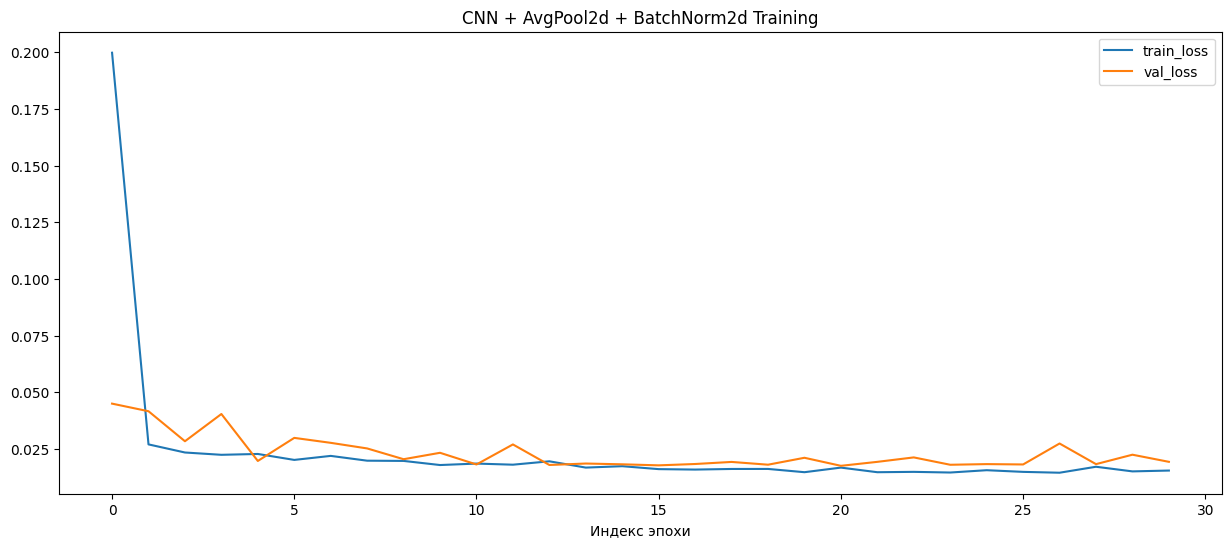

In [38]:
plt.figure(figsize=(15, 6))
for i in range(0, 4, 2):
    plt.plot(np.array(history)[:, i], '-')
plt.legend(['train_loss', 'val_loss'])
plt.xlabel('Индекс эпохи')
plt.title('CNN + AvgPool2d + BatchNorm2d Training')

Text(0.5, 1.0, 'CNN + AvgPool2d + BatchNorm2d Training')

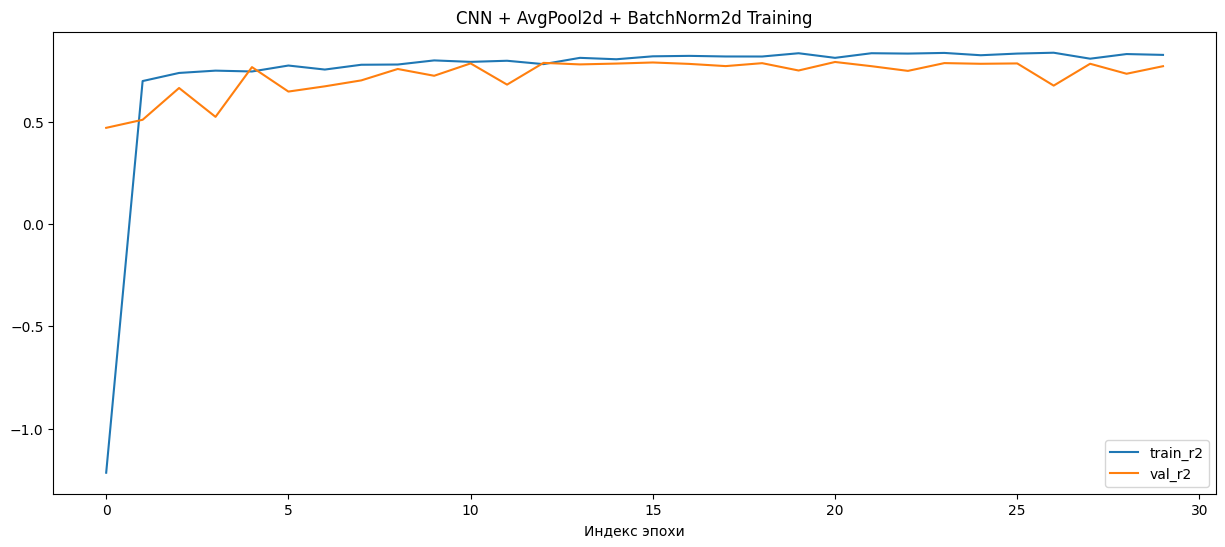

In [40]:
plt.figure(figsize=(15, 6))
for i in range(1, 4, 2):
    plt.plot(np.array(history)[:, i], '-')
plt.legend(['train_r2', 'val_r2'])
plt.xlabel('Индекс эпохи')
plt.title('CNN + AvgPool2d + BatchNorm2d Training')

In [ ]:
plt.figure(figsize=(15, 6))
for i in range(0, 4, 2):
    plt.plot(np.array(history)[:, i], '-')
plt.legend(['train_loss', 'val_loss'])
plt.xlabel('Индекс эпохи')
plt.title('CNN + AvgPool2d + BatchNorm2d Training')

In [24]:
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
criterion = nn.MSELoss()
_, cur_score = eval_epoch(convnetv2, test_loader, criterion)
cur_score

0.7847087859110932

Модели, основанные на идее использования сверток, показали свою эффективность, был получен хороший результат **0.775** и **0.785** соответственно. Наилучшим решением оказалась сверточная нейронная сеть с 4 сверточными слоями, содержащими батч-нормализацию.

## Сегментация поражений листьев растений
Ссылка на датасет: [https://www.kaggle.com/datasets/fakhrealam9537/leaf-disease-segmentation-dataset](https://www.kaggle.com/datasets/fakhrealam9537/leaf-disease-segmentation-dataset)

*Датасет уже загружен, находится в директории "./dataset/dataset2/"

В рамках этого задания необходимо:
1. Выбрать модель для сегментации
2. Подобрать метрику оценки точности модели
3. Обучить модель
4. Продемонстрировать результаты

Будет большим плюсом:
* Выбрать и обучить несколько моделей и провести сравнение результатов
* Произвести оценку модели по нескольким метрикам
* Продемонстрировать, как использовать обученную модель

Далее приведен пример демонстрации, которую ожидается получить

В качестве метрики было принято использовать метрику Intersection over Union (сокр. **IoU**). 

In [134]:
img_folder = pathlib.Path("dataset/dataset2/aug_data/aug_data/images")
mask_folder = pathlib.Path("dataset/dataset2/aug_data/aug_data/masks")

images = sorted([str(i) for i in img_folder.iterdir()])
masks = sorted([str(i) for i in mask_folder.iterdir()])

In [135]:
images = [imread(i) for i in images]
masks = [imread(i) for i in masks]

In [136]:
size = (256, 256)
X = [resize(x, size, mode='constant', anti_aliasing=True,) for x in images]
Y = [resize(y, size, mode='constant', anti_aliasing=False) > 0 for y in masks]

In [137]:
import numpy as np

X = np.array(X, np.float32)
Y = np.array(Y, np.float32)
print(f'Loaded {len(X)} images')

Loaded 2940 images


In [138]:
np.unique(Y)

array([0., 1.], dtype=float32)

In [139]:
X.shape, Y.shape

((2940, 256, 256, 3), (2940, 256, 256))

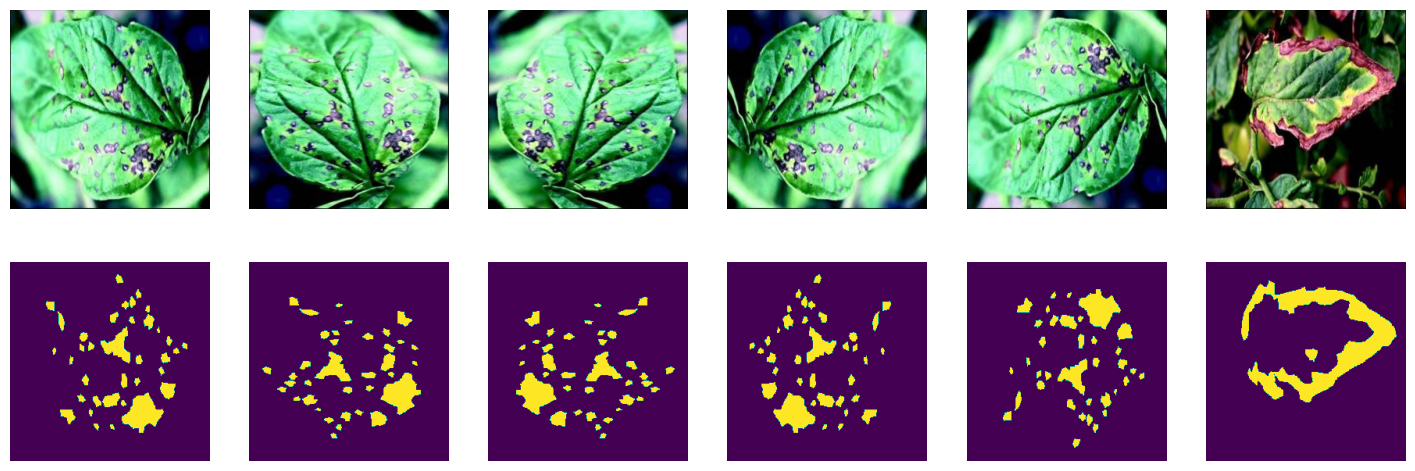

In [140]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

plt.figure(figsize=(18, 6))
for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.axis("off")
    plt.imshow(X[i])

    plt.subplot(2, 6, i+7)
    plt.axis("off")
    plt.imshow(Y[i])
plt.show();

In [141]:
ix = np.random.choice(len(X), len(X))
tr, val, ts = np.split(ix, [2000, 2300])

In [142]:
print(len(tr), len(val), len(ts))

2000 300 640


In [143]:
batch_size = 6
data_tr = DataLoader(list(zip(np.rollaxis(X[tr], 3, 1), Y[tr, np.newaxis])),
                     batch_size=batch_size, shuffle=True)
data_val = DataLoader(list(zip(np.rollaxis(X[val], 3, 1), Y[val, np.newaxis])),
                      batch_size=batch_size, shuffle=True)
data_ts = DataLoader(list(zip(np.rollaxis(X[ts], 3, 1), Y[ts, np.newaxis])),
                     batch_size=batch_size, shuffle=True)

In [144]:
class DiceBCELoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceBCELoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        inputs = F.sigmoid(inputs)       

        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).sum()                            
        dice_loss = 1 - (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
        BCE = F.binary_cross_entropy(inputs, targets, reduction='mean')
        Dice_BCE = BCE + dice_loss
        
        return Dice_BCE

# **Модель 1. UNet + Dice Loss**

In [145]:
net = torch.hub.load('milesial/Pytorch-UNet', 'unet_carvana', pretrained=True)
net.outc = torch.nn.Conv2d(64, 1, kernel_size=(1, 1), stride=(1, 1))
net = net.to(device)

# for p in list(net.parameters())[-5:]:
#     p.requires_grad=True

# for p in net.parameters():
#     p.requires_grad = True

Using cache found in /root/.cache/torch/hub/milesial_Pytorch-UNet_master


In [28]:
import torch.nn as nn
from torchmetrics.classification import Dice

In [147]:
def iou_pytorch(outputs: torch.Tensor, labels: torch.Tensor):
    # You can comment out this line if you are passing tensors of equal shape
    # But if you are passing output from UNet or something it will most probably
    # be with the BATCH x 1 x H x W shape
    outputs = outputs.squeeze(1).byte()  # BATCH x 1 x H x W => BATCH x H x W
    labels = labels.squeeze(1).byte()
    SMOOTH = 1e-8
    intersection = (outputs & labels).float().sum((1, 2))  # Will be zero if Truth=0 or Prediction=0
    union = (outputs | labels).float().sum((1, 2))         # Will be zzero if both are 0

    iou = (intersection + SMOOTH) / (union + SMOOTH)  # We smooth our devision to avoid 0/0
    
    thresholded = torch.clamp(20 * (iou - 0.5), 0, 10).ceil() / 10  # This is equal to comparing with thresolds

    return thresholded  #

In [148]:
def predict(model, data):
    model.eval()  # testing mode
    Y_pred = [X_batch for X_batch, _ in data]
    return np.array(Y_pred)

In [149]:
def score_model(model, metric, data, is_deeplab=False):
    model.eval()  # testing mode
    scores = 0
    for X_batch, Y_label in data:
        X_batch, Y_label = X_batch.to(device), Y_label.to(device)
        if is_deeplab: 
            Y_pred = (model(X_batch)['out'] > 0.5).float()
        else:
            Y_pred = (model(X_batch) > 0.5).float()
        scores += metric(Y_pred, Y_label).mean().item()

    return scores / len(data)

In [150]:
def train(model, opt, loss_fn, epochs, data_tr, data_val, is_deeplab=False):
    X_val, Y_val = next(iter(data_val))

    loss_history = []
    score_history = []
    time_all_epochs = 0
    for epoch in range(epochs):
#         tic = time()
        print('* Epoch %d/%d' % (epoch+1, epochs))

        avg_loss = 0
        model.train()  # train mode
        for X_batch, Y_batch in data_tr:
            # data to device
            X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)
            # set parameter gradients to zero
            opt.zero_grad()
            # forward
            if is_deeplab:
                Y_pred = model(X_batch)['out'].to(device)
            else:
                Y_pred = model(X_batch).to(device)
#             print(Y_batch.shape, Y_pred.shape)
            loss = loss_fn(Y_pred, Y_batch)
            loss.backward() # backward-pass
            opt.step()  # update weights

            # calculate loss to show the user
            avg_loss += loss / len(data_tr)
#         toc = time()
        print('loss: %f' % avg_loss)
        loss_history.append(avg_loss.item())
        cur_score = score_model(model, iou_pytorch, data_val, is_deeplab)
        score_history.append(cur_score)
#         time_all_epochs += toc-tic
        # show intermediate results
        model.eval() # testing mode
        if is_deeplab:
            Y_hat = (model(X_val.to(device))['out'] > 0.5).detach().cpu()
        else:
            Y_hat = (model(X_val.to(device)) > 0.5).detach().cpu()

        # Visualize tools
        clear_output(wait=True)
        for k in range(6):
            plt.subplot(2, 6, k+1)
            plt.imshow(np.rollaxis(X_val[k].numpy(), 0, 3), cmap='gray')
            plt.title('Real')
            plt.axis('off')

            plt.subplot(2, 6, k+7)
            plt.imshow(Y_hat[k, 0], cmap='gray')
            plt.title('Output')
            plt.axis('off')
        plt.suptitle('%d / %d - loss: %f, iou: %f' % (epoch+1, epochs, avg_loss, cur_score))
        plt.show()
    return loss_history, score_history #, time_all_epochs

In [52]:
from torchvision.ops import sigmoid_focal_loss

In [71]:
ALPHA = 0.5
BETA = 0.5

class TverskyLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(TverskyLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1, alpha=ALPHA, beta=BETA):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = F.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        #True Positives, False Positives & False Negatives
        TP = (inputs * targets).sum()    
        FP = ((1-targets) * inputs).sum()
        FN = (targets * (1-inputs)).sum()
       
        Tversky = (TP + smooth) / (TP + alpha*FP + beta*FN + smooth)  
        
        return 1 - Tversky

In [ ]:
optimizer = torch.optim.AdamW(net.parameters())
criterion = DiceBCELoss()

history_unet, score_unet = train(net, optimizer, criterion, 80, data_tr, data_val)

Text(0.5, 1.0, 'UNet + Dice Loss Training')

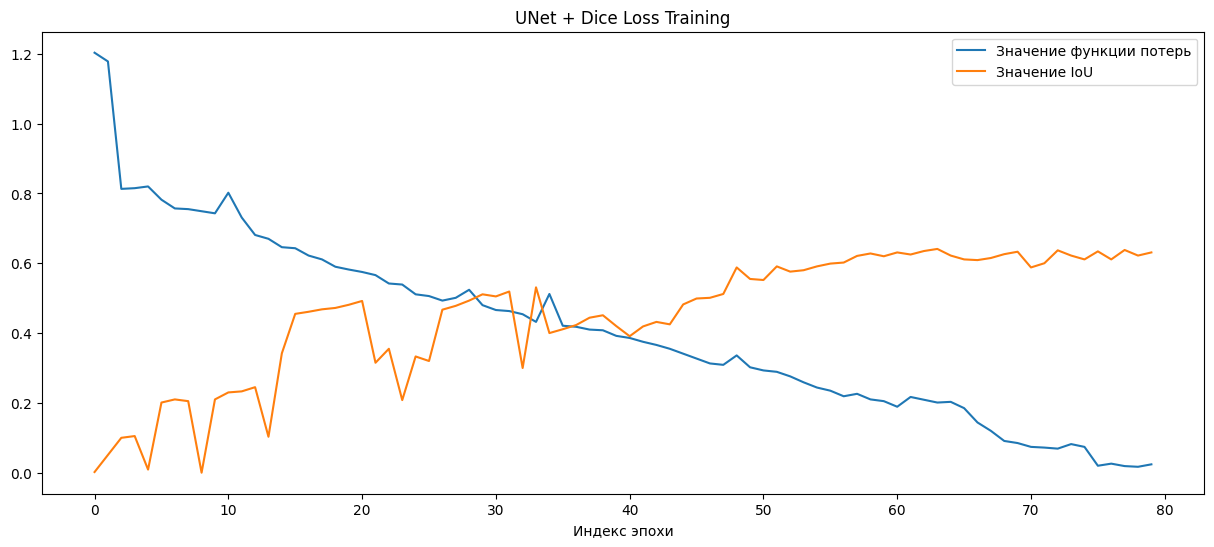

In [169]:
plt.figure(figsize=(15, 6))

plt.plot(history_unet, '-')
plt.plot(score_unet, '-')
plt.legend(['Значение функции потерь', 'Значение IoU'])
plt.xlabel('Индекс эпохи')
plt.title('UNet + Dice Loss Training')

In [89]:
score_model(net, iou_pytorch, data_ts)

0.41479752707147155

In [87]:
torch.save(net, 'segnet_80_epochs.pt')

In [91]:
np.max(score_unet)

0.6393333637714386

In [90]:
np.max(score_unet), np.argmax(score_unet)

(0.6393333637714386, 7)

Таким образом, лучшее значение IoU, которое дает UNet - **0.64**.

# **Модель 2. DeepLabV3 + Dice Loss**

In [47]:
deeplabv3 = torch.hub.load('pytorch/vision:v0.10.0', 'deeplabv3_resnet101', pretrained=True)
deeplabv3.eval()
deeplabv3.classifier[-1] = nn.Conv2d(256, 1, kernel_size=(1, 1), stride=(1, 1))
deeplabv3.aux_classifier[-1] = nn.Conv2d(256, 1, kernel_size=(1, 1), stride=(1, 1))
deeplabv3 = deeplabv3.to(device)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


In [48]:
a = torch.rand(4, 3, 256, 256).to(device)
deeplabv3(a)['out'].size()

torch.Size([4, 1, 256, 256])

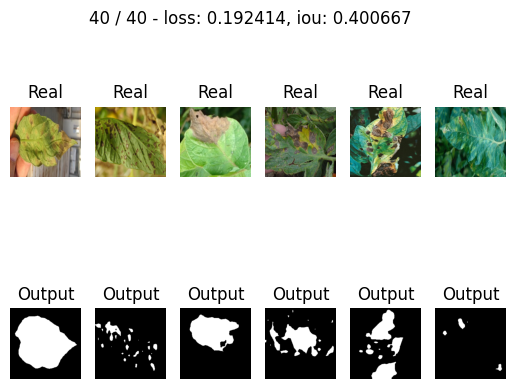

In [57]:
optimizer = torch.optim.AdamW(deeplabv3.parameters())
criterion = DiceBCELoss()

history_deeplab, score_deeplab = train(deeplabv3, optimizer, criterion, 40, data_tr, data_val, is_deeplab=True)

In [60]:
score_model(deeplabv3, iou_pytorch, data_ts, is_deeplab=True)

0.4221962808727104

In [61]:
np.max(score_deeplab), np.argmax(score_deeplab)

(0.5113333570957184, 38)

Text(0.5, 1.0, 'DeepLabV3 Training')

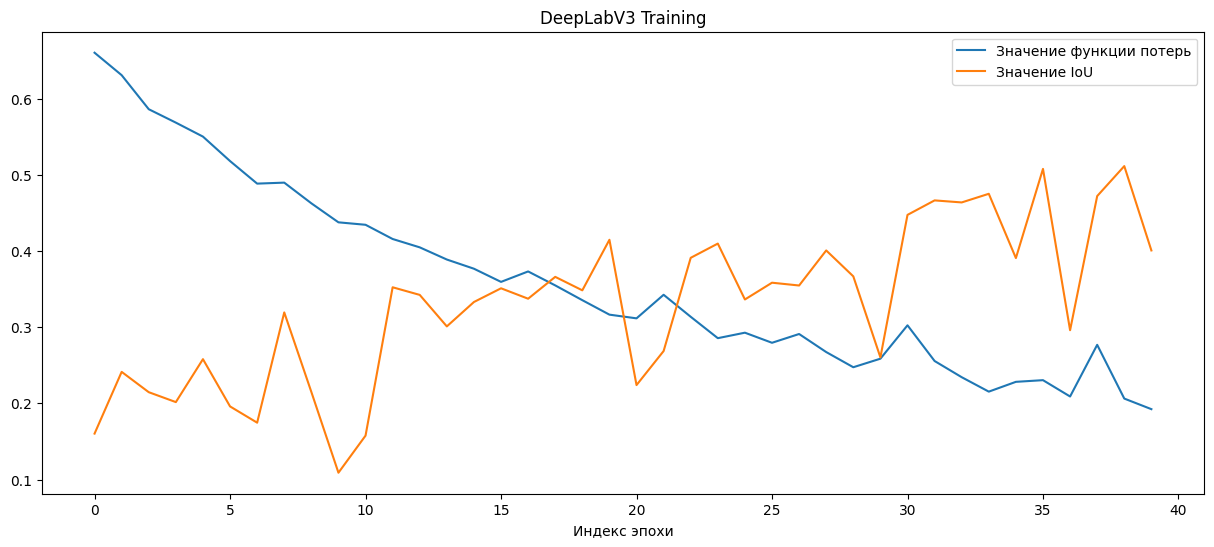

In [65]:
plt.figure(figsize=(15, 6))

plt.plot(history_deeplab, '-')
plt.plot(score_deeplab, '-')
plt.legend(['Значение функции потерь', 'Значение IoU'])
plt.xlabel('Индекс эпохи')
plt.title('DeepLabV3 Training')

In [68]:
torch.save(deeplabv3, 'deeplabv3_40_epochs.pt')

In [69]:
from IPython.display import FileLink

FileLink('deeplabv3_40_epochs.pt')

/kaggle/working/deeplabv3_40_epochs.pt

In [70]:
from IPython.display import FileLink

FileLink('deeplabv3_30_epochs.pt')

/kaggle/working/deeplabv3_30_epochs.pt

In [71]:
pathes = list(zip(image_names, mask_names))

i = 0
image_count = 5
for (image_name, mask_name) in pathes[:image_count]:
    img = np.array(Image.open(image_name))
    mask = np.array(ImageOps.grayscale(Image.open(mask_name)))

    transformed_mask = np.where(mask != 0, 200, 0)
    expanded_mask = np.zeros((*transformed_mask.shape, 3), dtype=transformed_mask.dtype)

    expanded_mask[..., 0] = transformed_mask

    new_mask = expanded_mask.copy()
    new_mask[..., 1] = transformed_mask
    new_mask[..., 2] = transformed_mask

    image_with_mask = np.clip(img + expanded_mask, 0, 255)

    plt.figure(figsize=(16, 8))
    _ = plt.subplot(1, 3, 1)
    plt.title("Оригинальное изображение")
    plt.imshow(img)
    _ = plt.subplot(1, 3, 2)
    plt.title("Маска изображения")
    plt.imshow(new_mask)
    _ = plt.subplot(1, 3, 3)
    plt.title("Изображение с маской")
    plt.imshow(image_with_mask)
plt.show()

NameError: name 'image_names' is not defined

Итог: наилучший результат показала модель **UNet** с **Dice Loss**.

## Сегментация пространства между клетками
Ссылка на датасет: [https://www.kaggle.com/datasets/user164919/hutu-80](https://www.kaggle.com/datasets/user164919/hutu-80)

*Датасет уже загружен, находится в директории "./dataset/dataset3/"

В оригинальном датасете необходимо сегментировать пространство с клетками. Нашим же заданием является сегментация пространства между клетками.

В рамках этого задания необходимо:
1. Выбрать модель для сегментации
2. Подобрать метрику оценки точности модели
3. Обучить модель
4. Продемонстрировать результаты

Будет большим плюсом:
* Выбрать и обучить несколько моделей и провести сравнение результатов
* Произвести оценку модели по нескольким метрикам
* Продемонстрировать, как использовать обученную модель

Далее приведен пример демонстрации, которую ожидается получить

Так же, как и в прошлой задаче, будет использоваться метрика **IoU**.

In [42]:
img_folder_dataset3 = pathlib.Path("dataset/dataset3/images")
mask_folder_dataset3 = pathlib.Path("dataset/dataset3/masks")

images_dataset3 = sorted([str(i) for i in img_folder_dataset3.iterdir()])
masks_dataset3 = sorted([str(i) for i in mask_folder_dataset3.iterdir()])

images_dataset3 = [imread(i) for i in images_dataset3]
masks_dataset3 = [imread(i)[:, :, 0] for i in masks_dataset3]

In [43]:
from skimage.transform import resize

size = (256, 256)
X_dataset3 = [resize(x, size, mode='constant', anti_aliasing=True,) for x in images_dataset3]
Y_dataset3 = [resize(y, size, mode='constant', anti_aliasing=False) == 0 for y in masks_dataset3]

In [44]:
X_dataset3 = np.array(X_dataset3, np.float32)
Y_dataset3 = np.array(Y_dataset3, np.float32)
print(f'Loaded {len(X_dataset3)} images')

Loaded 180 images


In [45]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

plt.figure(figsize=(18, 6))
for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.axis("off")
    plt.imshow(X_dataset3[i])

    plt.subplot(2, 6, i+7)
    plt.axis("off")
    plt.imshow(Y_dataset3[i])
plt.show();

In [50]:
tr_dataset3, val_dataset3, ts_dataset3 = np.split(np.random.choice(len(X_dataset3), len(X_dataset3)), [90, 135])

In [51]:
len(tr_dataset3), len(val_dataset3), len(ts_dataset3)

(90, 45, 45)

In [52]:
from torch.utils.data import DataLoader
import torch.nn as nn

batch_size = 16
data_tr_dataset3 = DataLoader(list(zip(np.rollaxis(X_dataset3[tr_dataset3], 3, 1), Y_dataset3[tr_dataset3, np.newaxis])),
                     batch_size=batch_size, shuffle=True)
data_val_dataset3 = DataLoader(list(zip(np.rollaxis(X_dataset3[val_dataset3], 3, 1), Y_dataset3[val_dataset3, np.newaxis])),
                      batch_size=batch_size, shuffle=True)
data_ts_dataset3 = DataLoader(list(zip(np.rollaxis(X_dataset3[ts_dataset3], 3, 1), Y_dataset3[ts_dataset3, np.newaxis])),
                     batch_size=batch_size, shuffle=True)

# **Модель 1. UNet + Dice Loss**

In [53]:
net_dataset3 = torch.hub.load('milesial/Pytorch-UNet', 'unet_carvana', pretrained=True)
net_dataset3.outc = torch.nn.Conv2d(64, 1, kernel_size=(1, 1), stride=(1, 1))
net_dataset3 = net_dataset3.to(device)

# for p in list(net.parameters())[-5:]:
#     p.requires_grad=True

for p in net_dataset3.parameters():
    p.requires_grad = True

/opt/conda/lib/python3.10/site-packages/torch/hub.py:294: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/milesial/Pytorch-UNet/zipball/master" to /root/.cache/torch/hub/master.zip
Downloading: "https://github.com/milesial/Pytorch-UNet/releases/download/v3.0/unet_carvana_scale0.5_epoch2.pth" to /root/.cache/torch/hub/checkpoints/unet_carvana_scale0.5_epoch2.pth
100%|██████████| 118M/118M [00:00<00:00, 217MB/s]  


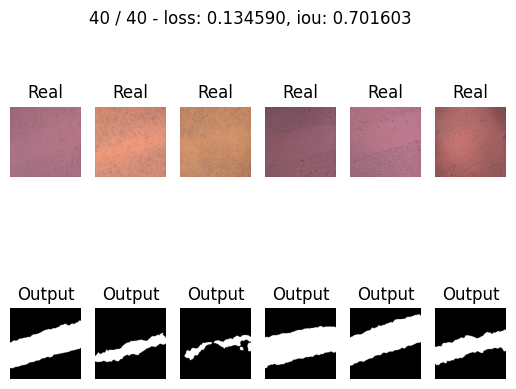

In [61]:
optimizer = torch.optim.AdamW(net_dataset3.parameters())
criterion = DiceBCELoss()

history_unet_dataset3, score_unet_dataset3 = train(net_dataset3, optimizer, criterion, 40, data_tr_dataset3, data_val_dataset3)

Text(0.5, 1.0, 'UNet + Dice Loss Training')

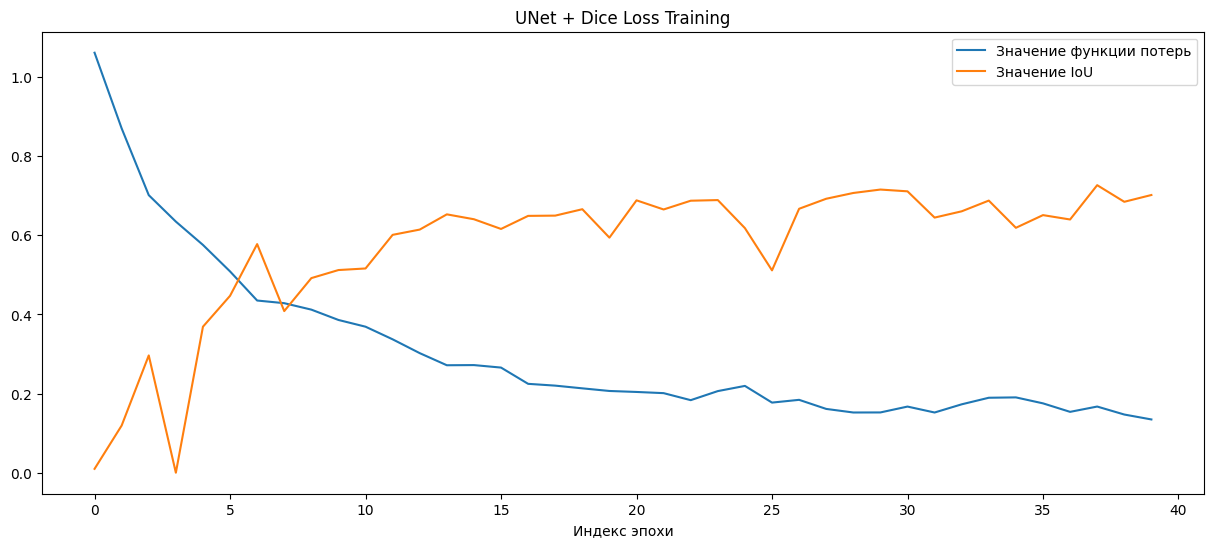

In [90]:
plt.figure(figsize=(15, 6))

plt.plot(history_unet_dataset3, '-')
plt.plot(score_unet_dataset3, '-')
plt.legend(['Значение функции потерь', 'Значение IoU'])
plt.xlabel('Индекс эпохи')
plt.title('UNet + Dice Loss Training')

In [91]:
score_model(net_dataset3, iou_pytorch, data_ts_dataset3)

0.7168269753456116

In [179]:
torch.save(net_dataset3, '/kaggle/working/unet_dice_40_epochs.pt')

In [181]:
from IPython.display import FileLink

FileLink('unet_dice_40_epochs.pt')

/kaggle/working/CLIP/unet_dice_40_epochs.pt

# **Модель 2. UNet + Tversky Loss**

In [69]:
net_dataset3_tversky = torch.hub.load('milesial/Pytorch-UNet', 'unet_carvana', pretrained=True)
net_dataset3_tversky.outc = torch.nn.Conv2d(64, 1, kernel_size=(1, 1), stride=(1, 1))
net_dataset3_tversky = net_dataset3.to(device)

# for p in list(net.parameters())[-5:]:
#     p.requires_grad=True

# for p in net_dataset3_tversky.parameters():
#     p.requires_grad = True

Using cache found in /root/.cache/torch/hub/milesial_Pytorch-UNet_master


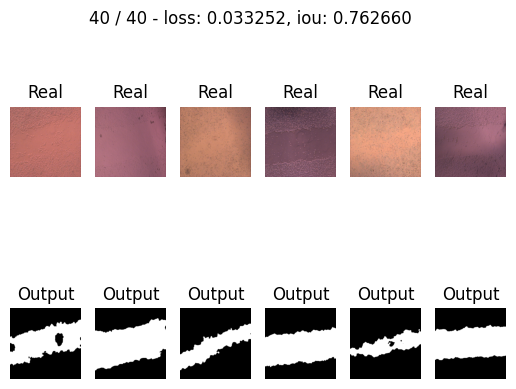

In [75]:
optimizer = torch.optim.AdamW(net_dataset3_tversky.parameters())
criterion = TverskyLoss()

history_unet_dataset3_tversky, score_unet_dataset3_tversky = train(net_dataset3_tversky, optimizer, criterion, 40, data_tr_dataset3, data_val_dataset3)

Text(0.5, 1.0, 'UNet + TverskyLoss Training')

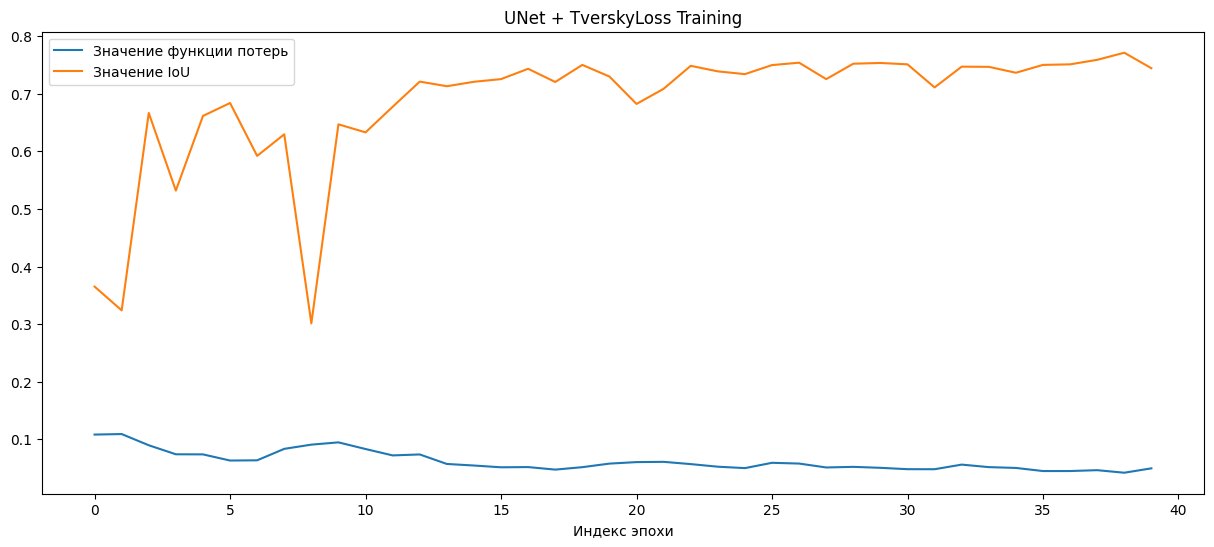

In [74]:
plt.figure(figsize=(15, 6))

plt.plot(history_unet_dataset3_tversky, '-')
plt.plot(score_unet_dataset3_tversky, '-')
plt.legend(['Значение функции потерь', 'Значение IoU'])
plt.xlabel('Индекс эпохи')
plt.title('UNet + Tversky Loss Training')

In [41]:
score_model(net_dataset3_tversky, iou_pytorch, data_ts_dataset3)

0.7593750208616257

In [184]:
torch.save(net_dataset3_tversky, '/kaggle/working/unet_tversky_40_epochs.pt')

In [190]:
FileLink('unet_tversky_40_epochs.pt')

/kaggle/working/CLIP/unet_tversky_40_epochs.pt

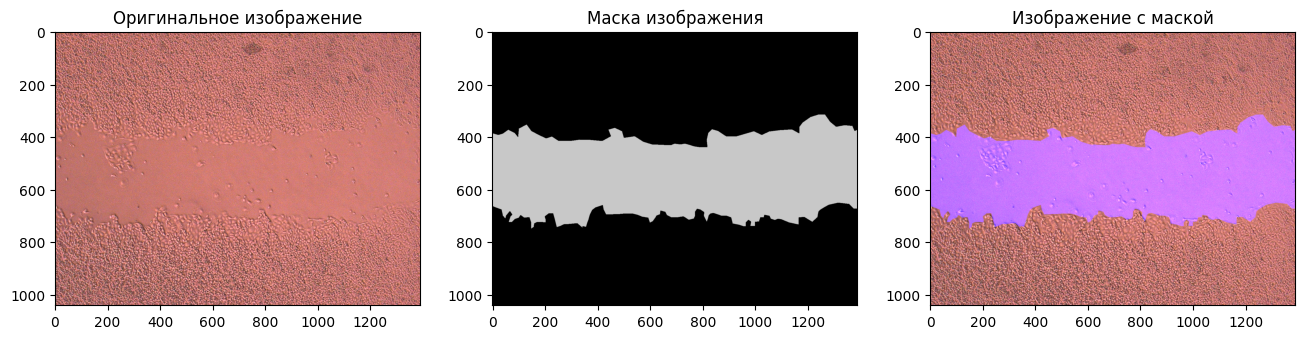

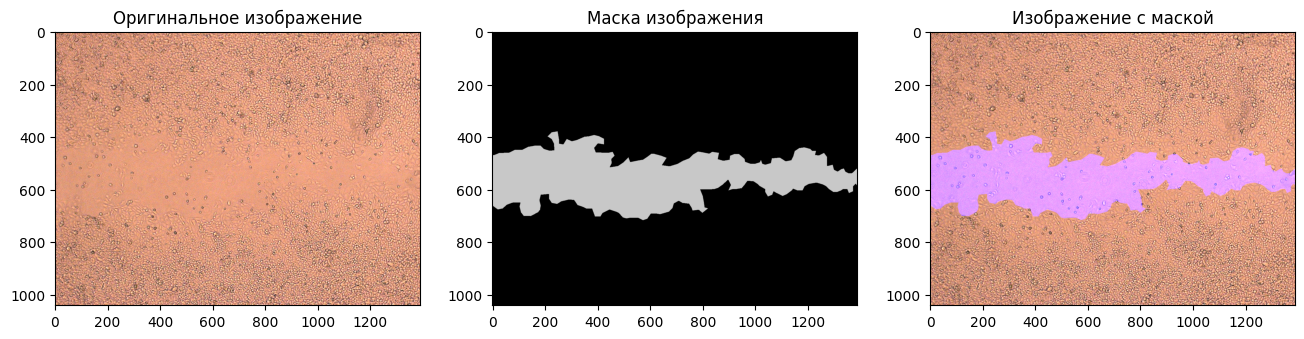

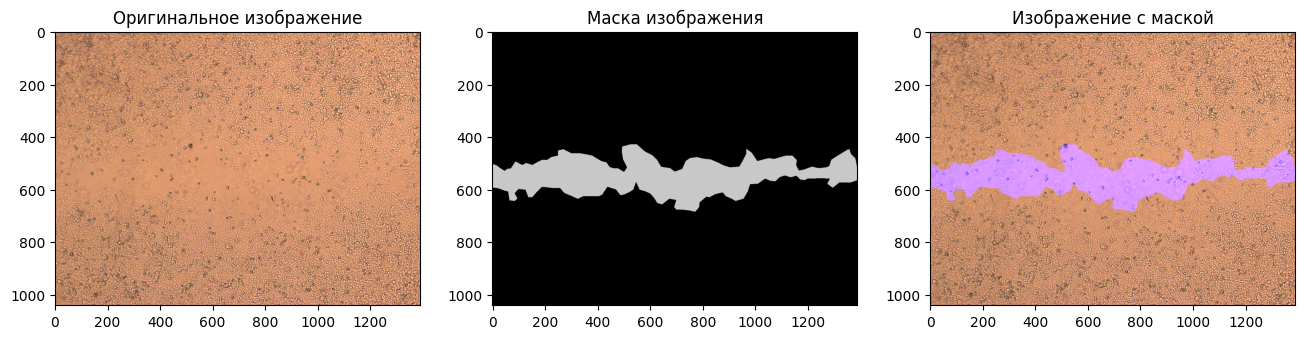

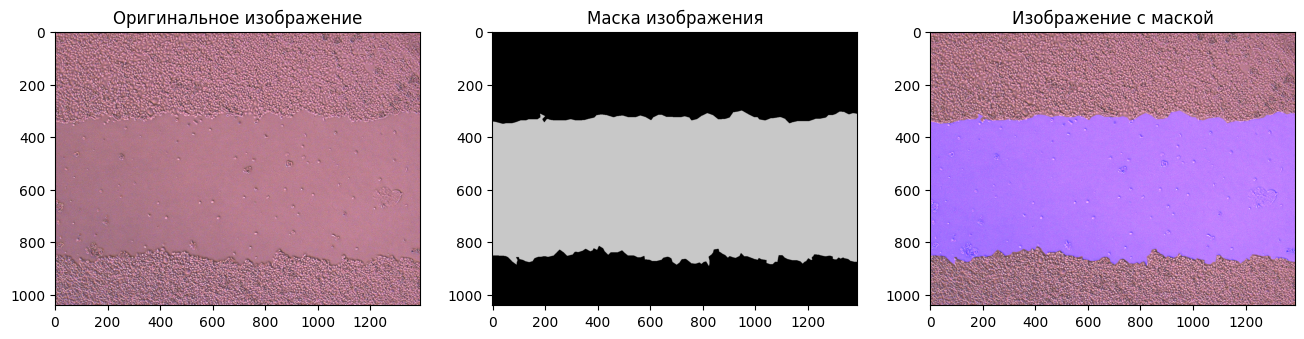

In [41]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image, ImageOps


img_folder = pathlib.Path("dataset/dataset3/images")
mask_folder = pathlib.Path("dataset/dataset3/masks")

image_names = [str(i) for i in img_folder.iterdir()]
image_names.sort()
mask_names = [str(i) for i in mask_folder.iterdir()]
mask_names.sort()

pathes = list(zip(image_names, mask_names))

i = 0
image_count = 5
for (image_name, mask_name) in pathes[:image_count]:
    img = np.array(Image.open(image_name))
    mask = np.array(ImageOps.grayscale(Image.open(mask_name)))

    transformed_mask = np.where(mask == 0, 200, 0)
    expanded_mask = np.zeros((*transformed_mask.shape, 3), dtype=transformed_mask.dtype)

    expanded_mask[..., 2] = transformed_mask

    new_mask = expanded_mask.copy()
    new_mask[..., 1] = transformed_mask
    new_mask[..., 0] = transformed_mask

    image_with_mask = np.clip(img + expanded_mask, 0, 255)

    plt.figure(figsize=(16, 8))
    _ = plt.subplot(1, 3, 1)
    plt.title("Оригинальное изображение")
    plt.imshow(img)
    _ = plt.subplot(1, 3, 2)
    plt.title("Маска изображения")
    plt.imshow(new_mask)
    _ = plt.subplot(1, 3, 3)
    plt.title("Изображение с маской")
    plt.imshow(image_with_mask)
    plt.show()